# Eliminación de Variables Críticas y Análisis con PCA

In [2]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import hdbscan
import umap
import xgboost as xgb
from lime.lime_tabular import LimeTabularExplainer

# Cargar el dataset
file_path = r"C:\Users\Omar\Downloads\Projecte_ML\dataset.csv" 
df = pd.read_csv(file_path)

# Ver las primeras filas
df.head()

,id,age,year,sex,glang,part,job,stud_h,health,psyt,jspe,qcae_cog,qcae_aff,amsp,erec_mean,cesd,stai_t,mbi_ex,mbi_cy,mbi_ea
0,2,18,1,1,120,1,0,56,3,0,88,62,27,17,0.738095,34,61,17,13,20
1,4,26,4,1,1,1,0,20,4,0,109,55,37,22,0.690476,7,33,14,11,26
2,9,21,3,2,1,0,0,36,3,0,106,64,39,17,0.690476,25,73,24,7,23
3,10,21,2,2,1,0,1,51,5,0,101,52,33,18,0.833333,17,48,16,10,21
4,13,21,3,1,1,1,0,22,4,0,102,58,28,21,0.690476,14,46,22,14,23


In [3]:
# Eliminar columnas no relevantes
df = df.drop(columns=['id'])

In [4]:
# Seleccionar las columnas numéricas para análisis
df_num = df[['age', 'jspe', 'qcae_cog', 'qcae_aff', 'amsp', 'erec_mean', 'cesd', 'stai_t', 'mbi_ex', 'mbi_cy', 'mbi_ea']]

# Estandarizar los datos
scaler = StandardScaler()
df_num_scaled = scaler.fit_transform(df_num)


In [5]:
# Eliminar variables críticas
df_num_reduced = df_num.drop(columns=['cesd', 'stai_t', 'mbi_ex'])

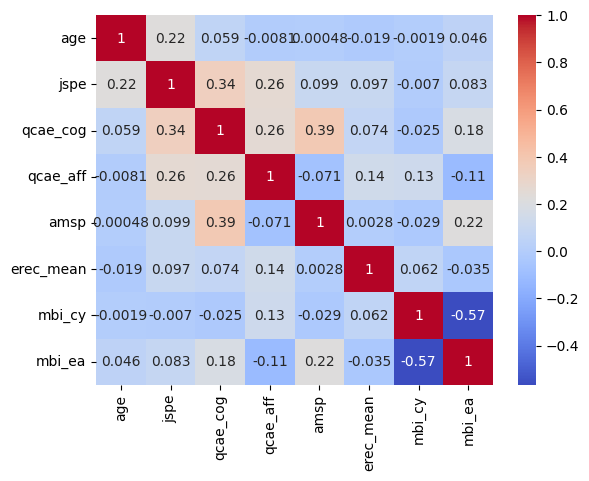

In [6]:
# Correlación de las variables restantes
corr_matrix_reduced = df_num_reduced.corr()
sns.heatmap(corr_matrix_reduced, annot=True, cmap='coolwarm')
plt.show()

In [7]:
# Estandarizar los datos reducidos
scaler = StandardScaler()
df_num_scaled_reduced = scaler.fit_transform(df_num_reduced)

In [8]:
# Aplicar PCA
pca = PCA(n_components=0.95)
pca_features_reduced = pca.fit_transform(df_num_scaled_reduced)

In [9]:
# Imprimir la varianza explicada
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

Explained Variance Ratio: [0.23051058 0.20430947 0.13640134 0.12948562 0.11161926 0.07734836
 0.0605012 ]


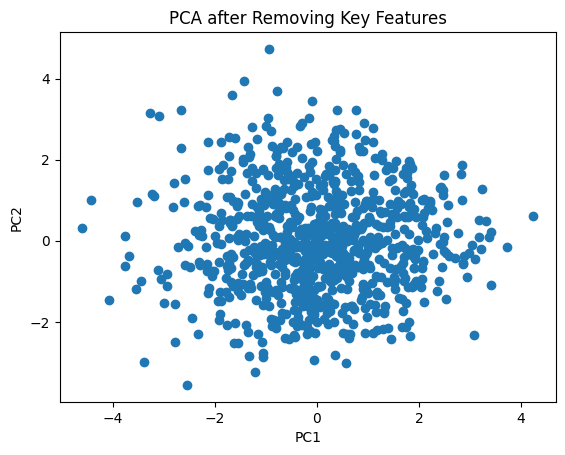

In [10]:
# Visualización del PCA
plt.scatter(pca_features_reduced[:, 0], pca_features_reduced[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA after Removing Key Features')
plt.show()

## Visualización de Varianza Explicada del PCA

In [11]:
# Cálculo de la varianza acumulada
pca = PCA(n_components=0.95)
pca.fit(df_num_scaled_reduced)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()

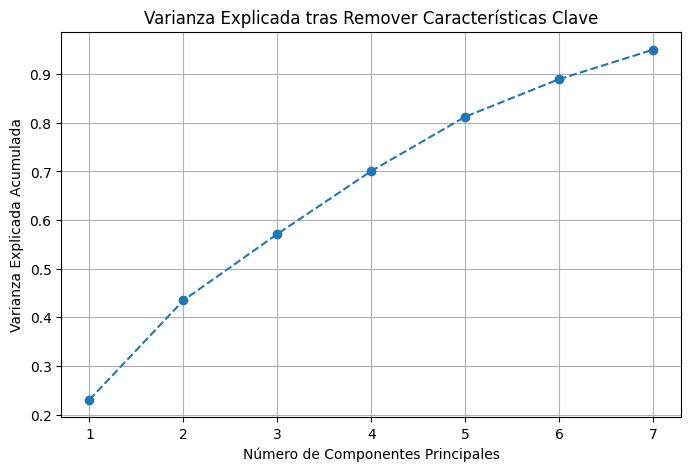

In [12]:
# Visualización de la varianza acumulada
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada tras Remover Características Clave')
plt.grid()
plt.show()

## Clustering con KMeans

In [13]:
# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters_reduced = kmeans.fit_predict(pca_features_reduced)

In [14]:
# Evaluar el clustering con Silhouette Score
sil_score = silhouette_score(pca_features_reduced, clusters_reduced)
print(f"Silhouette Score after removing key features: {sil_score}")

Silhouette Score after removing key features: 0.1402427575143946


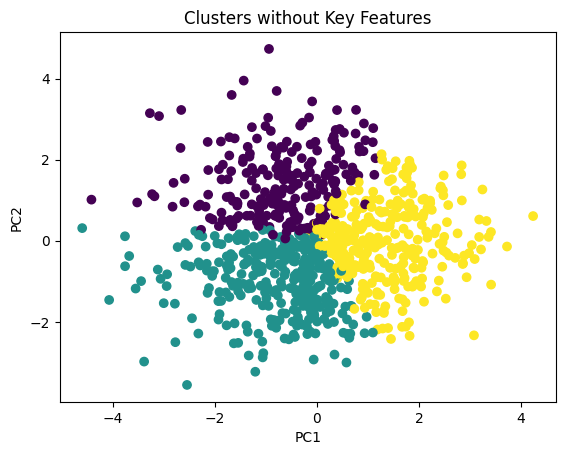

In [15]:
# Visualización de los clusters
plt.scatter(pca_features_reduced[:, 0], pca_features_reduced[:, 1], c=clusters_reduced, cmap='viridis')
plt.title('Clusters without Key Features')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## DBSCAN Clustering

In [16]:
# Crear nueva columna
df_num['academic_job_score'] = df['stud_h'] * df['job']

C:\Users\Omar\AppData\Local\Temp\ipykernel_24904\4015618824.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num['academic_job_score'] = df['stud_h'] * df['job']


In [17]:
# Aplicar DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=5)
clusters_dbscan = dbscan.fit_predict(pca_features_reduced)

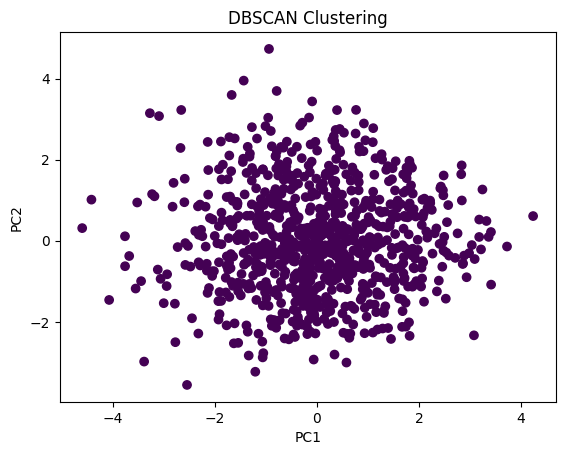

In [18]:
# Visualización de los clusters DBSCAN
plt.scatter(pca_features_reduced[:, 0], pca_features_reduced[:, 1], c=clusters_dbscan, cmap='viridis')
plt.title('DBSCAN Clustering')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## Resultados Agrupados

In [19]:
# Crear una copia del dataframe con clusters asignados
cluster_df = df_num_reduced.copy()
cluster_df['Cluster'] = clusters_reduced
print(cluster_df.groupby('Cluster').mean())

               age        jspe   qcae_cog   qcae_aff       amsp  erec_mean  \
Cluster                                                                      
0        22.349138  108.301724  58.517241  37.245690  22.103448   0.747537   
1        21.526154   99.960000  54.326154  31.667692  21.753846   0.685568   
2        23.255319  111.352584  62.680851  36.127660  25.267477   0.734983   

            mbi_cy     mbi_ea  
Cluster                        
0        15.181034  19.456897  
1         8.790769  24.563077  
2         7.753799  27.206687  
